# Setup

In [1]:
# Common imports
import sys
import os
import random
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import PIL
from google.cloud import storage

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Google Cloud Storage Properties
bucket_name = 'iot-lego-sorter.appspot.com'
folder = 'datasets'
storage_client = storage.Client.from_service_account_json('service_account.json')
bucket = storage_client.bucket(bucket_name)

# Directories
localDir = 'images/lego/'

# Images
imgWidth = 64
imgHeight = 64

# List available buckets.

In [2]:
buckets = list(storage_client.list_buckets())
print(buckets)

[<Bucket: iot-lego-sorter.appspot.com>, <Bucket: staging.iot-lego-sorter.appspot.com>]


# Download files from Google Storage

Get available files in datasets.

In [3]:
blobs = storage_client.list_blobs(bucket_name, prefix=folder)
fileNameByBrickId = {}

for blob in blobs:
    nameNoFolder = blob.name[len(folder)+1:]
    split = nameNoFolder.split('/')
    
    if(len(split) > 1):
        id = split[0];
        fileDir = blob.name;
        
        if(id in fileNameByBrickId):
            fileNameByBrickId[id].append(fileDir)
        else:
            fileNameByBrickId[id] = [fileDir]
print('Retrieved all filenames')

Retrieved all filenames


In [4]:
# Metode til at Downloade billeder hvis de ikke allerede er downloaded.
def downloadFile(fileName):
    nameNoFolder = fileName[len(folder)+1:]
    testFileDir = localDir + nameNoFolder
    testDir = os.path.dirname(testFileDir)
    
    if not os.path.isfile(testFileDir):
        if not os.path.exists(testDir):
            os.makedirs(testDir)
        blob = bucket.blob(fileName)
        blob.download_to_filename(testFileDir)
    
    return testFileDir

In [5]:

localFileNameByBrickId = {}
for key in fileNameByBrickId.keys():
    print(key)
    localFileNameByBrickId[key] = []
    listLenStr = str(len(fileNameByBrickId[key]))
    for index, fileName in enumerate(fileNameByBrickId[key]):
        print(str(index+1).zfill(len(listLenStr)) + '/' + listLenStr + ' - ' + fileName + (' ' * 256), end='\r')
        localFileNameByBrickId[key].append(downloadFile(fileName))
    print(listLenStr + '/' + listLenStr + ' - Finished downloading' + (' ' * 256))
print('\nFinished all downloads')

3001


0978/1621 - datasets/3001/b64f3b66-387e-11eb-b2e9-b827eba365e0.jpg                                                                                                                                                                                                                                                                

1449/1621 - datasets/3001/f042bfd6-387f-11eb-b3ed-b827eba365e0.jpg                                                                                                                                                                                                                                                                

1621/1621 - Finished downloading                                                                                                                                                                                                                                                                
3003


0438/1322 - datasets/3003/51ee17ce-388c-11eb-8176-b827eba365e0.jpg                                                                                                                                                                                                                                                                

0952/1322 - datasets/3003/c670db32-3881-11eb-b611-b827eba365e0.jpg                                                                                                                                                                                                                                                                

0995/1322 - datasets/3003/ce05a810-3880-11eb-8137-b827eba365e0.jpg                                                                                                                                                                                                                                                                

1322/1322 - Finished downloading                                                                                                                                                                                                                                                                
3004


1129/1627 - datasets/3004/a0d05f2e-3886-11eb-ab60-b827eba365e0.jpg                                                                                                                                                                                                                                                                

1627/1627 - Finished downloading                                                                                                                                                                                                                                                                

Finished all downloads


# Make images into multidimensional arrays

In [6]:
# Metode til at konvertere billede til multidimensionelt array.
def convertImageToArray(fileName):
    an_image = PIL.Image.open(fileName).convert('L')
    image_sequence = an_image.getdata()
    return np.array(image_sequence).reshape(imgWidth, imgHeight)

In [7]:
IndexToBrickId = {}
brickIdImageKeyPairs = []
# Sammensætter index & billeder
for index, key in enumerate(localFileNameByBrickId.keys()):
    print(key)
    IndexToBrickId[index] = key
    listLenStr = str(len(localFileNameByBrickId[key]))
    for index2, fileName in enumerate(localFileNameByBrickId[key]):
        print(str(index2+1).zfill(len(listLenStr)) + '/' + listLenStr + ' - ' + fileName + (' ' * 256), end='\r')
        brickIdImageKeyPairs.append((index, convertImageToArray(fileName)))
    print(listLenStr + '/' + listLenStr + ' - Finished converting\n')
print('\nFinished converting all')

3001
1621/1621 - Finished convertingda95cc-387f-11eb-b3ed-b827eba365e0.jpg                                                                                                                                                                                                                                                                     

3003
1322/1322 - Finished convertingd56b6e-3880-11eb-8137-b827eba365e0.jpg                                                                                                                                                                                                                                                                     

3004
1627/1627 - Finished convertingbff7d2-3887-11eb-a31b-b827eba365e0.jpg                                                                                                                                                                                                                                                            

# Randomize order

In [8]:
# Tilføjer billeder & indexes & shuffle inden
IndexesForBrickId = []
images = []
random.shuffle(brickIdImageKeyPairs)
for item in brickIdImageKeyPairs:
    IndexesForBrickId.append(item[0])
    images.append(item[1])
    

# Splitting datasets and normalizing


In [9]:
# Tager en procentdel af datasættet til træning og en procentdel til test.
percentageToTakeTrainFull = int(len(IndexesForBrickId) * 0.8)

# Her skalerer vi pixel intensiteten til mellem 0-1, konverterer til float ved at dividerer med 255
images = np.asarray(images) / 255.

print('Train ' + str(percentageToTakeTrainFull) + '/' + str(len(IndexesForBrickId)))
X_train_full = np.asarray(images[:percentageToTakeTrainFull])
y_train_full = np.asarray(IndexesForBrickId[:percentageToTakeTrainFull])

X_test = np.asarray(images[percentageToTakeTrainFull:])
y_test = np.asarray(IndexesForBrickId[percentageToTakeTrainFull:])


Train 3656/4570


In [10]:
# Størrelsen på træningssætet & dimensionerne samt datatype
print(X_train_full.shape)
# Hver pixel intensity er repræsenteret en float mellem 0 - 1
print(X_train_full.dtype)

(3656, 64, 64)
float64


In [11]:
percentageToTakeForValidation = int(len(X_train_full) * 0.1)
print('Length of Validation set ' + str(percentageToTakeForValidation) + ' / ' + str(len(X_train_full)))

# Splitter træningssættet til en validation og en lidt mindre træningssæt
X_valid, X_train = X_train_full[:percentageToTakeForValidation], X_train_full[percentageToTakeForValidation:]
y_valid, y_train = y_train_full[:percentageToTakeForValidation], y_train_full[percentageToTakeForValidation:]

Length of Validation set 365 / 3656


In [12]:
print("Training Set shape: {0}".format(X_train.shape))
print("Test Set shape: {0}".format(X_test.shape))
print("Valid Set Shape: {0}".format(X_valid.shape))


Training Set shape: (3291, 64, 64)
Test Set shape: (914, 64, 64)
Valid Set Shape: (365, 64, 64)


# Build a model using the Sequential API

### Method to create model with parameters

In [13]:
def build_model(var_activation='relu',var_optimizer='adam', var_neurons='50', var_hiddenL=2, var_lr=0.005, var_momentum = 0.5):

    model = keras.models.Sequential()
    # Input layer:
    # Flatten layer konverterer hvert input billede til et 1 dimensionelt array.
    model.add(keras.layers.Flatten(input_shape=[imgWidth, imgHeight]))

    # Hidden layers:
    # Tilføjer hidden layers
    for h in range(var_hiddenL):
        model.add(keras.layers.Dense(var_neurons, activation=var_activation)),

    # Output layer.
    # Laget skal indeholde en neuron pr. klasse, dvs. i det her tilfælde 3 neurons
    # Da det er multiclass classification skal vi bruge softmax activation function
    # Det sørger for, at de estimerede sandsynligheder er mellem 0 og 1.
    model.add(keras.layers.Dense(3, activation="softmax"))
    # Modellen bliver kompileret
    if var_optimizer.lower() == 'sgd':
        model.compile(loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.SGD(lr=var_lr, momentum=var_momentum),
        metrics=["accuracy"])
    elif var_optimizer.lower() == 'adam': 
        
        model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=keras.optimizers.Adam(learning_rate=var_lr),
                  metrics=["accuracy"])
    else:
                model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=var_optimizer,
                  metrics=["accuracy"])
    return model


In [14]:
## RandomizedSearchCV, prøver og at finde de bedste parametrer. 

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV


kerasModel = KerasClassifier(build_model, epochs=30)

# Vælger de forskellige parameter der skal blive brugt i forbindelse med RandomizedSearchCV
_optimizers=['SGD', 'Adam']
_neurons=[60, 80, 100]
_batch_size=[16,32,64]
_activations=['relu','selu']
_hiddenLayer=[2, 4]
_lr=[0.005, 0.010, 0.0005]
_momentum=[0.5, 0.7]
params=dict(var_activation=_activations,
            var_optimizer=_optimizers,
            batch_size=_batch_size,
            var_neurons=_neurons,
            var_hiddenL=_hiddenLayer,
            var_lr=_lr,
            var_momentum=_momentum)

rscv = RandomizedSearchCV(kerasModel, param_distributions=params, cv=3,n_iter=10)
rscv_results = rscv.fit(X_train, y_train, validation_data=(X_valid, y_valid))
## Får printet ud de bedste score & parameterere
print('Best score is: {} using {}'.format(rscv_results.best_score_,
rscv_results.best_params_))


"## RandomizedSearchCV, prøver og at finde de bedste parametrer. \n\nfrom tensorflow.keras.wrappers.scikit_learn import KerasClassifier\nfrom sklearn.model_selection import RandomizedSearchCV\n\n\nkerasModel = KerasClassifier(build_model, epochs=30)\n\n# Vælger de forskellige parameter der skal blive brugt i forbindelse med RandomizedSearchCV\n_optimizers=['SGD', 'Adam']\n_neurons=[60, 80, 100]\n_batch_size=[16,32,64]\n_activations=['relu','selu']\n_hiddenLayer=[2, 4]\n_lr=[0.005, 0.010, 0.0005]\n_momentum=[0.5, 0.7]\nparams=dict(var_activation=_activations,\n            var_optimizer=_optimizers,\n            batch_size=_batch_size,\n            var_neurons=_neurons,\n            var_hiddenL=_hiddenLayer,\n            var_lr=_lr,\n            var_momentum=_momentum)\n\nrscv = RandomizedSearchCV(kerasModel, param_distributions=params, cv=3,n_iter=10)\nrscv_results = rscv.fit(X_train, y_train, validation_data=(X_valid, y_valid))\n## Får printet ud de bedste score & parameterere\nprint('

In [15]:
model_sgd = build_model('relu', 'sgd', 100, 2, 0.005, 0.5)
hidden1_sgd = model_sgd.layers[1]

weights_sgd, biases_sgd = hidden1_sgd.get_weights()
print("Weights:\n {0}\n\nShape of weights {1}\n".format(weights_sgd, weights_sgd.shape))
print("Biases:\n {0}\n\nShape of biases {1}".format(biases_sgd, biases_sgd.shape))

Weights:
 [[ 0.01244565 -0.00446159 -0.01112634 ... -0.03061662 -0.03129685
   0.00943727]
 [-0.00979345  0.00105156  0.00932661 ...  0.01820592  0.00963846
  -0.00203224]
 [ 0.02388653  0.03647797  0.02223715 ... -0.01405906  0.01961463
  -0.03501691]
 ...
 [-0.01125773 -0.0209567  -0.0128921  ... -0.02753955 -0.00510684
   0.015696  ]
 [ 0.03164969 -0.00712359  0.02786249 ... -0.02712684 -0.03517146
   0.00973044]
 [-0.00226299 -0.01755748 -0.01300627 ...  0.01392413  0.01202735
  -0.00047806]]

Shape of weights (4096, 100)

Biases:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]

Shape of biases (100,)


## Train the model (SGD)

In [16]:
print(y_train)
# Laver earlyStopping og træner modellen. Earlystopping ruller tilbage til den bedste model
earlyStopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model_sgd.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_data=(X_valid, y_valid), 
                    callbacks=[earlyStopping_cb])

[1 1 1 ... 2 0 1]
Epoch 1/30
103/103 [==============================] - 1s 5ms/step - loss: 1.0187 - accuracy: 0.5090 - val_loss: 0.9083 - val_accuracy: 0.5781
Epoch 2/30
103/103 [==============================] - 0s 4ms/step - loss: 0.8474 - accuracy: 0.6612 - val_loss: 0.6997 - val_accuracy: 0.8082
Epoch 3/30
103/103 [==============================] - 0s 4ms/step - loss: 0.6838 - accuracy: 0.7596 - val_loss: 0.5462 - val_accuracy: 0.8493
Epoch 4/30
103/103 [==============================] - 0s 4ms/step - loss: 0.5355 - accuracy: 0.8110 - val_loss: 0.4004 - val_accuracy: 0.9370
Epoch 5/30
103/103 [==============================] - 0s 4ms/step - loss: 0.4536 - accuracy: 0.8335 - val_loss: 0.3345 - val_accuracy: 0.9534
Epoch 6/30
103/103 [==============================] - 0s 4ms/step - loss: 0.3611 - accuracy: 0.8818 - val_loss: 1.1066 - val_accuracy: 0.5562
Epoch 7/30
103/103 [==============================] - 0s 4ms/step - loss: 0.4497 - accuracy: 0.8380 - val_loss: 0.2692 - val_accur

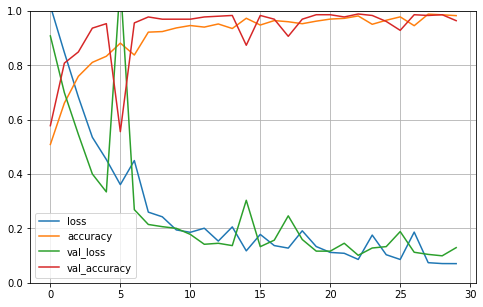

In [17]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Evaluate the SGD model.

In [18]:
model_sgd.evaluate(X_test, y_test)

29/29 [==============================] - 0s 2ms/step - loss: 0.1019 - accuracy: 0.9508


[0.10190709680318832, 0.95076584815979]

In [19]:
# Predictions med de første 3 instanser af test-sættet
X_new = X_test[:3]
y_pred = np.argmax(model_sgd.predict(X_new), axis=-1)
y_pred

array([1, 1, 1], dtype=int64)

In [20]:
# Ser hvis det er korrekt.
y_new = y_test[:3]
y_new

array([1, 1, 1])

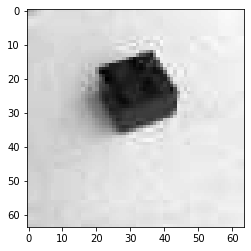

3003


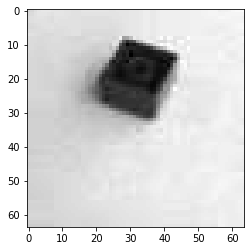

3003


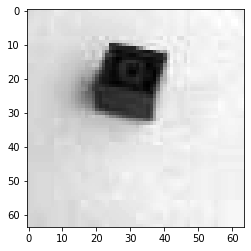

3003


In [21]:
# Legoklods billede & ID til legoklods
newClassList = np.array(list(IndexToBrickId.values()))[y_pred]
for i in range(3):
    plt.imshow(X_new[i], cmap='gray')
    plt.show()
    print(newClassList[i])

# Trainining the Model (Adam) & evaluating it.

In [22]:
model_adam = build_model('relu', 'adam', 60, 4, 0.0005)


In [23]:
history = model_adam.fit(X_train, y_train, epochs=30, batch_size=16,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
206/206 [==============================] - 1s 3ms/step - loss: 0.9687 - accuracy: 0.5147 - val_loss: 0.7388 - val_accuracy: 0.6795
Epoch 2/30
206/206 [==============================] - 1s 2ms/step - loss: 0.4153 - accuracy: 0.8645 - val_loss: 0.3646 - val_accuracy: 0.9068
Epoch 3/30
206/206 [==============================] - 0s 2ms/step - loss: 0.2314 - accuracy: 0.9256 - val_loss: 0.1667 - val_accuracy: 0.9644
Epoch 4/30
206/206 [==============================] - 0s 2ms/step - loss: 0.2087 - accuracy: 0.9274 - val_loss: 0.1775 - val_accuracy: 0.9507
Epoch 5/30
206/206 [==============================] - 0s 2ms/step - loss: 0.0990 - accuracy: 0.9757 - val_loss: 0.1956 - val_accuracy: 0.9507
Epoch 6/30
206/206 [==============================] - 0s 2ms/step - loss: 0.0913 - accuracy: 0.9748 - val_loss: 0.1100 - val_accuracy: 0.9863
Epoch 7/30
206/206 [==============================] - 0s 2ms/step - loss: 0.0928 - accuracy: 0.9742 - val_loss: 0.1049 - val_accuracy: 0.9808
Epoch 

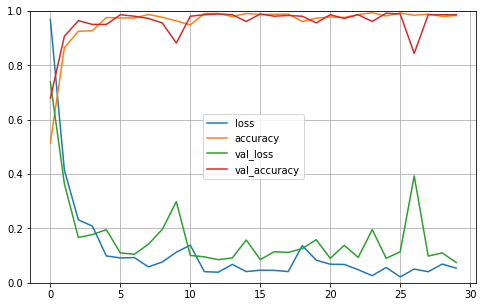

In [24]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [25]:
model_adam.evaluate(X_test, y_test)

29/29 [==============================] - 0s 1ms/step - loss: 0.0255 - accuracy: 0.9978


[0.025486193597316742, 0.9978117942810059]